<a href="https://colab.research.google.com/github/Mehedi615/100-days-of-python/blob/main/Code_2_(FinaL_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Analysis

### Primary Goals - 
* Find users that are going to churn in future?
* What factors drive users to churn?

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm #logistic regression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV #hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from xgboost import XGBClassifier
import warnings; warnings.simplefilter('ignore')

In [ ]:
#meta-data
v_dict = {"city": "city this user signed up in","phone": "primary device for this user","signup_date": "date of account registration; in the form `YYYYMMDD`",
"last_trip_date": "the last time this user completed a trip; in the form `YYYYMMDD`","avg_dist": "the average distance (in miles) per trip taken in the first 30 days after signup",
"avg_rating_by_driver": "the rider’s average rating over all of their trips","avg_rating_of_driver": "the rider’s average rating of their drivers over all of their trips", 
"surge_pct": "the percent of trips taken with surge multiplier > 1","avg_surge": "The average surge multiplier over all of this user’s trips", 
"trips_in_first_30_days": "the number of trips this user took in the first 30 days after signing up","luxury_car_user": "TRUE if the user took a luxury car in their first 30 days; FALSE otherwise",
"weekday_pct": "the percent of the user’s trips occurring during a weekday"}
#meta data information
pd.set_option('display.max_colwidth',-1)
pd.DataFrame(list(v_dict.items()),columns = ["variable","description"])

,variable,description
0,city,city this user signed up in
1,phone,primary device for this user
2,signup_date,date of account registration; in the form `YYYYMMDD`
3,last_trip_date,the last time this user completed a trip; in the form `YYYYMMDD`
4,avg_dist,the average distance (in miles) per trip taken in the first 30 days after signup
5,avg_rating_by_driver,the rider’s average rating over all of their trips
6,avg_rating_of_driver,the rider’s average rating of their drivers over all of their trips
7,surge_pct,the percent of trips taken with surge multiplier > 1
8,avg_surge,The average surge multiplier over all of this user’s trips
9,trips_in_first_30_days,the number of trips this user took in the first 30 days after signing up


## DATA

In [ ]:
import pandas as pd
from google.colab import files

In [ ]:
uploaded=files.upload()

Saving churn.csv to churn.csv


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "churn.csv" with length 3698747 bytes


In [ ]:
import io

In [ ]:
#loading data
data = pd.read_csv(io.StringIO(uploaded['churn.csv'].decode('utf-8')))
data.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
avg_dist,3.67,8.26,0.77,2.36,3.13,10.56,3.95,2.04,4.36,2.37
avg_rating_by_driver,5.0,5.0,5.0,4.9,4.9,5.0,4.0,5.0,5.0,5.0
avg_rating_of_driver,4.7,5.0,4.3,4.6,4.4,3.5,NaN,5.0,4.5,NaN
avg_surge,1.1,1.0,1.0,1.14,1.19,1.0,1.0,1.0,1.0,1.0
city,King's Landing,Astapor,Astapor,King's Landing,Winterfell,Winterfell,Astapor,Winterfell,Winterfell,Winterfell
last_trip_date,2014-06-17,2014-05-05,2014-01-07,2014-06-29,2014-03-15,2014-06-06,2014-01-25,2014-01-29,2014-02-01,2014-01-05
phone,iPhone,Android,iPhone,iPhone,Android,iPhone,Android,iPhone,Android,Android
signup_date,2014-01-25,2014-01-29,2014-01-06,2014-01-10,2014-01-27,2014-01-09,2014-01-24,2014-01-28,2014-01-21,2014-01-03
surge_pct,15.4,0.0,0.0,20.0,11.8,0.0,0.0,0.0,0.0,0.0
trips_in_first_30_days,4,0,3,9,14,2,1,2,2,1


In [ ]:
#Available Information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_dist                50000 non-null  float64
 1   avg_rating_by_driver    49799 non-null  float64
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   city                    50000 non-null  object 
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   signup_date             50000 non-null  object 
 8   surge_pct               50000 non-null  float64
 9   trips_in_first_30_days  50000 non-null  int64  
 10  luxury_car_user         50000 non-null  bool   
 11  weekday_pct             50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Basic information about data
- Every row represents a separate customer. The data has a total of 50,000 customers.
- Data types for columns last_trip_date and signup_date are wrong. Need to correct the type
- In total, we have 7 numerical variables; 2 categorical; 1 boolean and 2 date columns. We need to create a target variable.
- 3 variables have MISSING VALUES - avg_rating_by_driver; avg_rating_of_driver and phone.

In [ ]:
#Lets first convert columns to their appropriate data types
data.signup_date = data.signup_date.astype('datetime64')
data.last_trip_date = data.last_trip_date.astype("datetime64")

#### We need a response variable -- 

In [ ]:

print("------Last trip date decription-------")
print()
print(data.last_trip_date.describe())
print()
print("------Sign up date decription-------")
print()
print(data.signup_date.describe())

------Last trip date decription-------

count     50000              
unique    182                
top       2014-06-29 00:00:00
freq      2036               
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

------Sign up date decription-------

count     50000              
unique    31                 
top       2014-01-18 00:00:00
freq      2948               
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object


- So looks like, users signed up in January and have used the app till 1st of July, 2014.
- To create the target variable, we need to determine which users are active, and who have stopped using the application. Lets see the breakdown by each month

In [ ]:
#Lets see the breakdown by months
last_trip_bd = data.groupby(data['last_trip_date'].dt.strftime('%B')).last_trip_date.count()
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
last_trip_bd.index = pd.CategoricalIndex(last_trip_bd.index, categories=cats, ordered=True)
last_trip_bd = last_trip_bd.sort_index()
last_trip_bd

last_trip_date
January     10147
February    4308 
March       4568 
April       4588 
May         7585 
June        18256
July        548  
Name: last_trip_date, dtype: int64

- Clearly, users who have used the app in July and June, are customers who are still loyal to the company. However, customers who last used the app before June (in May or before) have gone by without using the app for a considerable time. Lets mark them as inactive (or users who have churned).

In [ ]:
#Any user whose last trip with the company was before 1st June, 2014 is considered to be "churned". 
data["churned"] = 1
data["churned"][data.last_trip_date >= "2014-06-01"] = 0
data.churned = data.churned.astype("category")

In [ ]:
#sanity check
data.head().transpose()

,0,1,2,3,4
avg_dist,3.67,8.26,0.77,2.36,3.13
avg_rating_by_driver,5.0,5.0,5.0,4.9,4.9
avg_rating_of_driver,4.7,5.0,4.3,4.6,4.4
avg_surge,1.1,1.0,1.0,1.14,1.19
city,King's Landing,Astapor,Astapor,King's Landing,Winterfell
last_trip_date,2014-06-17 00:00:00,2014-05-05 00:00:00,2014-01-07 00:00:00,2014-06-29 00:00:00,2014-03-15 00:00:00
phone,iPhone,Android,iPhone,iPhone,Android
signup_date,2014-01-25 00:00:00,2014-01-29 00:00:00,2014-01-06 00:00:00,2014-01-10 00:00:00,2014-01-27 00:00:00
surge_pct,15.4,0.0,0.0,20.0,11.8
trips_in_first_30_days,4,0,3,9,14


#### Duplicated values

In [ ]:
data[data.duplicated()].shape

(8, 13)

Although, we dont have a unique customer ID for each customer, having all values similar looks highly unlikely for 2 customers. There are 8 such rows in the data (customer having the same city, same phone, same signup_date, same last_trip_date looks highly unlikely)

In [ ]:
clean_data = data.copy()
clean_data.drop_duplicates(inplace = True)

In [ ]:

#We have a total of 49,992 customers
clean_data.shape

(49992, 13)

In [ ]:
#Since, we have used last_trip_date to create our target variable, we can drop the variable from further analysis
clean_data.drop(["last_trip_date"],axis = 1,inplace = True)

In [ ]:

#Before moving further, lets separate our variables based on their types
#Separating columns by data types
def separate(df):
    separated_cols = {
        "categorical" : list(df.select_dtypes(include = ["bool","object","category"]).columns),
        "continuous" : list(df.select_dtypes(include = ["int64","float64"]).columns),
        "date" : list(df.select_dtypes(include = ["datetime"]).columns)
    }
    return separated_cols

separate(clean_data)

{'categorical': ['city', 'phone', 'luxury_car_user', 'churned'],
 'continuous': ['avg_dist',
  'avg_rating_by_driver',
  'avg_rating_of_driver',
  'avg_surge',
  'surge_pct',
  'trips_in_first_30_days',
  'weekday_pct'],
 'date': ['signup_date']}

## Missing Values?

In [ ]:
clean_data.isnull().sum()

avg_dist                  0   
avg_rating_by_driver      201 
avg_rating_of_driver      8119
avg_surge                 0   
city                      0   
phone                     396 
signup_date               0   
surge_pct                 0   
trips_in_first_30_days    0   
luxury_car_user           0   
weekday_pct               0   
churned                   0   
dtype: int64

- Why does column "phone" have missing values? (The customer needs a phone to use the app - Could be an different OS- Need further look)
- Having missing values for ratings seem intuitive. Not all customers provide a rating to the drivers. Similar for Drivers.

## Lets analyze each variable individually - UNIVARIATE ANALYSIS

- TARGET Variable - CHURN

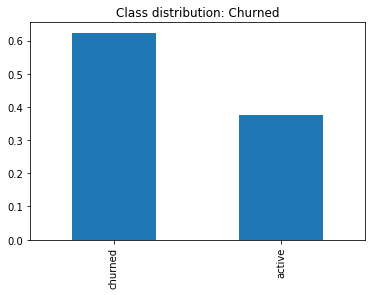

In [ ]:
#Churn distribution
clean_data.churned.value_counts(normalize = True).plot(kind = "bar",title = "Class distribution: Churned")
plt.xticks(np.arange(2),labels = ["churned","active"])
plt.show()

- the class distribution is almost 60/40. This is not ideal, but might work. We'll go ahead with the data as it is. Based on the results, we'll either up-sample/down-sample/use the SMOTE technique to balance the distribution.

#### Categorical variables

In [ ]:
cat_cols = separate(clean_data)["categorical"]
cat_cols.remove("churned")
cat_cols

['city', 'phone', 'luxury_car_user']

,city,phone,luxury_car_user
count,49992,49596,49992
unique,3,2,2
top,Winterfell,iPhone,False
freq,23331,34578,31141


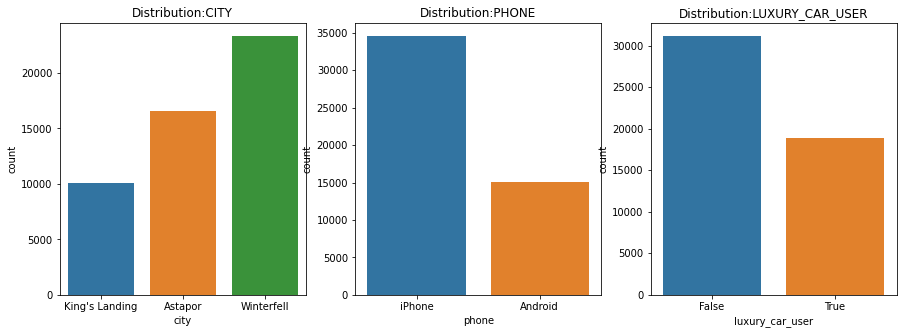

In [ ]:
fig, ax= plt.subplots(1,3, figsize = (15,5))
for i, col in enumerate(cat_cols):
    sns.countplot(x = col,data = clean_data, ax = ax[i])
    ax[i].set_title("Distribution:"+ col.upper())
clean_data[cat_cols].describe()

- Majority population comes from Winterfell, have an iphone and haven't used a luxury car in their first 30 days

#### Numerical Variables

In [ ]:
cont_cols = separate(clean_data)["continuous"]
clean_data[cont_cols].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,49992.00000,49791.000000,41873.000000,49992.000000,49992.000000,49992.000000,49992.000000
mean,5.79726,4.778123,4.601512,1.074776,8.850952,2.278405,60.929833
std,5.70761,0.446679,0.617360,0.222352,19.960094,3.792953,37.078229
min,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.42000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.88000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.94000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.96000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


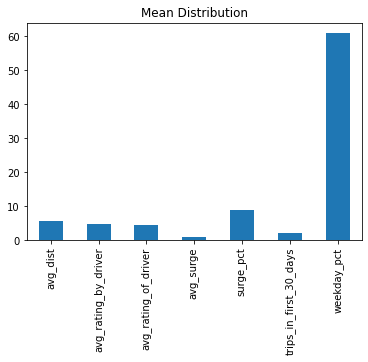

In [ ]:
clean_data[cont_cols].mean().plot(kind = "bar")
plt.title("Mean Distribution")
plt.show()

- We need to scale the numerical features, owing to such varied degree of means of variables

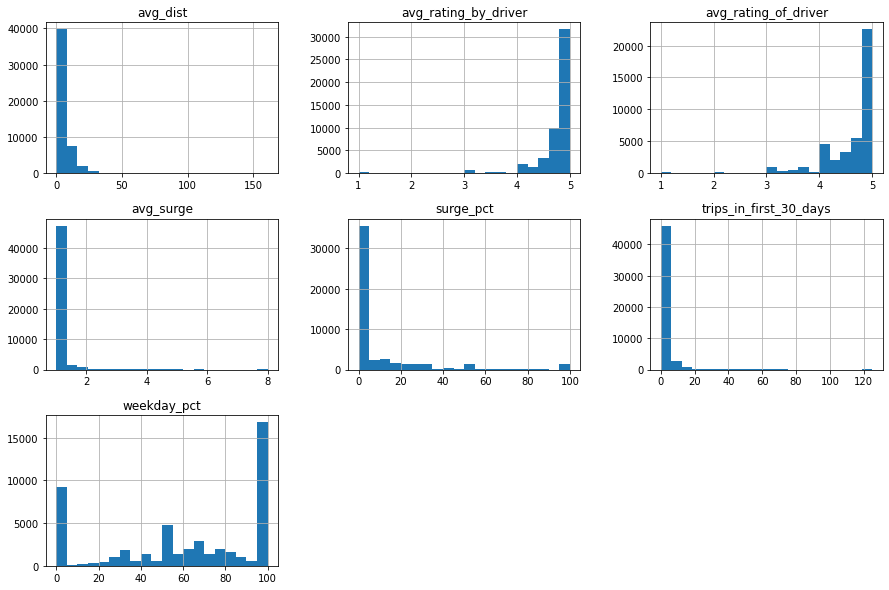

In [ ]:
clean_data[cont_cols].hist(figsize = (15,10),bins = 20)
plt.show()

### Insights
- Almost all varibales are skewed. We need to transform them.
- Customer/ Driver ratings can give us an insight into their behaviour and personality. We can create new features using the variable.
- Avg_surge has most obs. at 1 and surge_pct at 0. There could be some correlation here. Need further analysis.
- All outlier points need further investigation.

In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                49992 non-null  float64       
 1   avg_rating_by_driver    49791 non-null  float64       
 2   avg_rating_of_driver    41873 non-null  float64       
 3   avg_surge               49992 non-null  float64       
 4   city                    49992 non-null  object        
 5   phone                   49596 non-null  object        
 6   signup_date             49992 non-null  datetime64[ns]
 7   surge_pct               49992 non-null  float64       
 8   trips_in_first_30_days  49992 non-null  int64         
 9   luxury_car_user         49992 non-null  bool          
 10  weekday_pct             49992 non-null  float64       
 11  churned                 49992 non-null  category      
dtypes: bool(1), category(1), datetime64[ns](1), fl

## OUTLIERS

- Lets investigate outliers for every variable
#### Avg_dist

In [ ]:
clean_data[clean_data["avg_dist"] > 50].shape

(41, 12)

In [ ]:
clean_data[clean_data["avg_dist"] > 50].head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned
534,129.89,5.0,NaN,1.0,King's Landing,NaN,2014-01-04,0.0,0,False,0.0,1
799,60.58,5.0,5.0,1.0,Astapor,Android,2014-01-28,0.0,0,False,100.0,1
1302,79.69,5.0,5.0,1.0,Winterfell,iPhone,2014-01-30,0.0,1,False,100.0,1
1482,52.15,4.0,NaN,1.0,King's Landing,Android,2014-01-08,0.0,1,False,100.0,1
1493,72.08,5.0,5.0,1.0,Astapor,iPhone,2014-01-26,0.0,1,False,100.0,1


Why are trips_in_first_30_days = 0, when avg_dist travelled by customer is higher than 0?
- If customer did not take any trip after signing up (in first 30 days), then dist. travelled should be 0.

In [ ]:
clean_data[(clean_data["avg_dist"] > 0) & (clean_data["trips_in_first_30_days"] == 0)].shape

(15334, 12)

In [ ]:
clean_data[(clean_data["avg_dist"] > 0) & (clean_data["trips_in_first_30_days"] == 0)].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned
1,8.26,5.0,5.0,1.00,Astapor,Android,2014-01-29,0.0,0,False,50.0,1
13,3.04,5.0,4.0,1.38,King's Landing,iPhone,2014-01-29,50.0,0,False,50.0,0
17,2.38,4.8,3.9,1.00,King's Landing,iPhone,2014-01-12,0.0,0,True,95.2,0
19,12.08,5.0,5.0,1.17,King's Landing,iPhone,2014-01-02,33.3,0,False,66.7,0
22,11.47,5.0,NaN,1.00,Winterfell,iPhone,2014-01-24,0.0,0,False,100.0,1
23,7.74,5.0,5.0,1.00,King's Landing,Android,2014-01-21,0.0,0,True,100.0,0
28,5.97,5.0,NaN,1.50,Winterfell,iPhone,2014-01-19,100.0,0,False,0.0,0
37,1.38,5.0,4.0,1.00,Astapor,iPhone,2014-01-02,0.0,0,False,50.0,1
41,3.80,5.0,4.0,1.88,Winterfell,iPhone,2014-01-18,50.0,0,False,0.0,1
50,3.25,5.0,5.0,1.25,Winterfell,Android,2014-01-04,100.0,0,False,0.0,1


Woah! There are 15,000 such customers (thats 30% of observations)
- Something, definitely is wrong here. Given the variable description, either, the avg_dist is reported wrong or trips_in_first_30_days is not correct.
- Some of these customers also have used luxury car in first 30 days. That means, the customer definitely took a trip in first 30 days of his signup. Then why trips_in_first_30_days = 0?
- Looks like the variable has quality issues. We'll drop the variable from further analysis and not include it for modeling.

In [ ]:
clean_data.drop(["trips_in_first_30_days"],inplace = True, axis =1)

In [ ]:
#Lets look at remaining outliers
clean_data[clean_data["avg_dist"] == 0].shape

(149, 11)

In [ ]:
clean_data[clean_data["avg_dist"] == 0].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
72,0.0,3.0,5.0,1.0,Astapor,iPhone,2014-01-07,0.0,False,100.0,1
116,0.0,5.0,5.0,1.0,Winterfell,Android,2014-01-10,0.0,False,100.0,1
188,0.0,5.0,NaN,1.0,Winterfell,Android,2014-01-11,0.0,False,100.0,1
356,0.0,5.0,4.0,1.0,Winterfell,Android,2014-01-15,0.0,False,100.0,1
479,0.0,5.0,5.0,1.0,Winterfell,iPhone,2014-01-24,0.0,False,0.0,1
975,0.0,4.0,NaN,1.0,Winterfell,NaN,2014-01-26,0.0,True,0.0,1
1194,0.0,4.0,3.0,1.0,Winterfell,Android,2014-01-17,0.0,False,100.0,1
1519,0.0,5.0,5.0,1.0,Winterfell,Android,2014-01-22,0.0,False,100.0,1
1524,0.0,5.0,5.0,1.0,Winterfell,iPhone,2014-01-01,0.0,False,100.0,1
1575,0.0,5.0,4.0,1.0,Winterfell,iPhone,2014-01-18,0.0,False,0.0,1


- Evrything looks alright here!
#### Avg_ratings

In [ ]:
clean_data[clean_data.avg_rating_by_driver <=1].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
882,5.99,1.0,NaN,1.0,Winterfell,iPhone,2014-01-05,0.0,True,0.0,0
908,4.08,1.0,NaN,1.0,Astapor,Android,2014-01-18,0.0,True,0.0,1
936,2.60,1.0,NaN,1.0,Winterfell,iPhone,2014-01-24,0.0,False,100.0,1
991,3.80,1.0,3.0,1.0,Winterfell,iPhone,2014-01-22,0.0,False,50.0,0
1100,0.76,1.0,NaN,1.0,Astapor,iPhone,2014-01-29,0.0,True,0.0,0


In [ ]:
clean_data[clean_data.avg_rating_of_driver <=1].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
94,23.34,4.0,1.0,1.0,Astapor,iPhone,2014-01-17,0.0,True,0.0,1
169,2.11,5.0,1.0,1.0,Winterfell,iPhone,2014-01-24,0.0,True,100.0,1
230,18.61,2.0,1.0,1.0,Winterfell,iPhone,2014-01-06,0.0,True,100.0,1
474,9.01,5.0,1.0,1.0,Winterfell,Android,2014-01-31,0.0,False,0.0,1
568,2.41,5.0,1.0,1.0,Astapor,Android,2014-01-07,0.0,True,50.0,1


#### Surge Pricing

In [ ]:
clean_data[clean_data.avg_surge == 1].shape

(34446, 11)

In [ ]:
clean_data[clean_data.surge_pct == 0].shape

(34401, 11)

In [ ]:

clean_data[(clean_data.avg_surge == 1) & (clean_data.surge_pct != 0)].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,luxury_car_user,weekday_pct,churned
96,4.89,4.6,4.1,1.0,Winterfell,iPhone,2014-01-26,1.9,True,76.9,0
1385,1.78,4.8,5.0,1.0,King's Landing,iPhone,2014-01-02,1.9,True,61.1,0
3584,2.18,4.7,4.8,1.0,Astapor,iPhone,2014-01-30,2.0,True,92.0,0
4726,2.34,4.7,4.9,1.0,Winterfell,iPhone,2014-01-23,0.9,True,66.4,0
4847,3.47,4.9,3.9,1.0,Winterfell,iPhone,2014-01-06,1.5,True,81.8,0
5925,4.45,4.9,4.8,1.0,Winterfell,Android,2014-01-31,1.7,False,74.1,0
6495,2.11,4.7,3.9,1.0,Astapor,iPhone,2014-01-23,1.7,False,80.0,1
10291,2.45,4.5,5.0,1.0,King's Landing,iPhone,2014-01-29,0.9,True,74.3,0
10969,3.70,4.8,4.9,1.0,King's Landing,Android,2014-01-18,0.8,True,67.5,0
11781,2.29,4.7,4.0,1.0,Winterfell,iPhone,2014-01-06,1.7,True,55.0,0


Intuitively, there seems to be some correlation between avg. surge multiplier applied for all trips and trips taken with surge multiple greater than 1.
- But, there are 45 such customers, who have taken rides where avg surge was equal to 1, but their trips with surge > 1 is greater than 0. There can be a case of information lost in rounding the variable values. The avg_surge might not be truly 1.0 for such customers. For now, considering we have limited information, we will include these points as well.

#### Using app during the week?

In [ ]:

clean_data[(clean_data.weekday_pct != 0) & (clean_data.weekday_pct != 100)].shape

(24138, 11)

Almost half obervations/ customers have either taken all their trips during the week or haven't taken a single trip during the week.

## Replacing Missing Values

In [ ]:
clean_data["phone"] = clean_data["phone"].fillna("Other")

In [ ]:
clean_data["phone"].value_counts()

iPhone     34578
Android    15018
Other      396  
Name: phone, dtype: int64

In [ ]:
#Before replacing values for rating variables, lets create a separate variable indicating that values have been replaced here!
#clean_data["rating_by_driver_replaced"] = 0
#clean_data["rating_by_driver_replaced"][clean_data.avg_rating_by_driver.isnull()] = 1
#clean_data["rating_of_driver_replaced"] = 0
#clean_data["rating_of_driver_replaced"][clean_data.avg_rating_of_driver.isnull()] = 1

#Replacing ratings with median of the variable, since it is a highly skewed variable.
#clean_data["avg_rating_by_driver"] = clean_data["avg_rating_by_driver"].fillna(clean_data.avg_rating_by_driver.median())
#clean_data["avg_rating_of_driver"] = clean_data["avg_rating_of_driver"].fillna(clean_data.avg_rating_of_driver.median())

In [ ]:
clean_data.dropna(subset=["avg_rating_by_driver"], inplace=True)
clean_data.dropna(subset=["avg_rating_of_driver"], inplace=True)

In [ ]:
clean_data.isnull().sum()

avg_dist                0
avg_rating_by_driver    0
avg_rating_of_driver    0
avg_surge               0
city                    0
phone                   0
signup_date             0
surge_pct               0
luxury_car_user         0
weekday_pct             0
churned                 0
dtype: int64

- All the variables are now complete! Ting.

## Lets look at some relationships between variables - BIVARIATE ANALYSIS

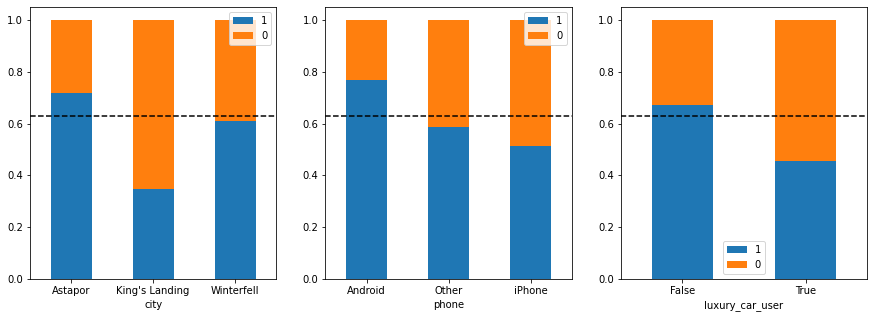

In [ ]:

fig,ax = plt.subplots(1,3,figsize = (15,5))
for i in range(len(separate(clean_data)["categorical"])-1):
    temp = clean_data.groupby(separate(clean_data)["categorical"][i])["churned"].value_counts(normalize = True).unstack()
    temp = temp[[1,0]]
    temp.plot(kind = "bar",stacked = True,rot = 0,ax = ax[i])
    ax[i].hlines(0.63,-10,100,linestyle = "dashed") #dashed line if the average customers churn rate
plt.show()

### Insights
- City Astapor is experiencing a higher churn rate than average. Customers are unhappy in Astapor. King's Landing is managing the operations really well. A very low churn rate.
- Android users are unhappy / churning - There can be various issues here for example - UI for the Android app is too complex/ difficult for customers or customers experiencing other problems.
- Customers taking a luxury car in first 30 days churn less. We should promote usage of luxury cars.

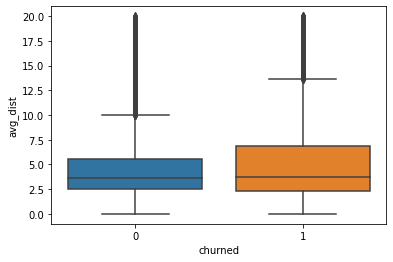

In [ ]:
#Limiting the outliers to understand the relationship
sns.boxplot(y = "avg_dist",x= "churned",data = clean_data[clean_data.avg_dist < 20])

Non-churners seem to travel less distances in their first 30 days. This might be due to churning customers using the app to travel once/twice for large distances and never coming back again.

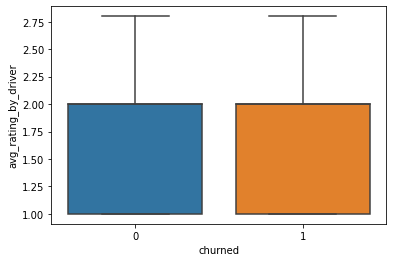

In [ ]:
sns.boxplot(y = "avg_rating_by_driver",x= "churned",data = clean_data[clean_data.avg_rating_by_driver < 3])

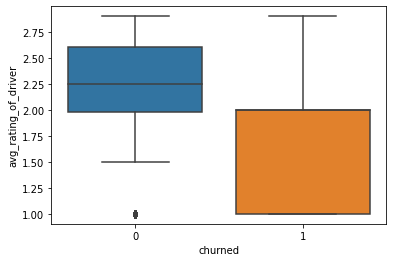

In [ ]:
sns.boxplot(y = "avg_rating_of_driver",x= "churned",data = clean_data[clean_data.avg_rating_of_driver < 3])

Customers unhappy with drivers seem to churn more!

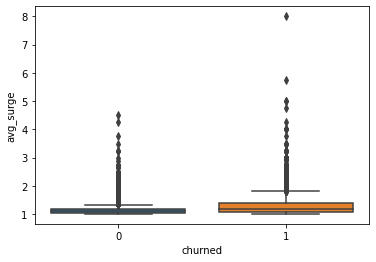

In [ ]:
sns.boxplot(y = "avg_surge",x= "churned",data = clean_data[(clean_data.avg_surge > 1)])

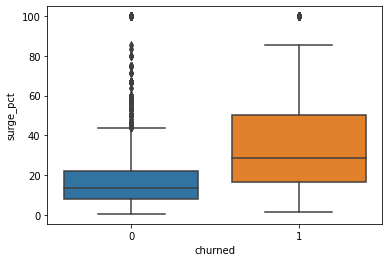

In [ ]:
sns.boxplot(y = "surge_pct",x= "churned",data = clean_data[clean_data.surge_pct >0])

Customers who have had higher % of surge rides seem to churn more! 

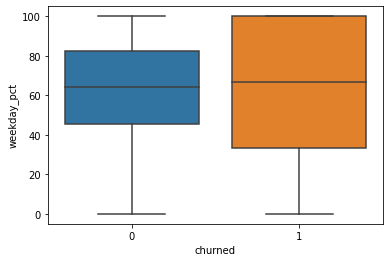

In [ ]:

sns.boxplot(y = "weekday_pct",x= "churned",data = clean_data)

Nothing interesting here!

## Insights summarize
- Customers in Astapor churn more
- Android customers churn more
- Users who have used luxury cars churn less
- Customers giving poor ratings to drivers churn more
- Users experiencing higher surge charge are likely to churn more.

### Some relationships that we can explore based on the insights
- Are the customers in city Astapor experiencing higher surge or are they have poor experiences with drivers?
- Are Android users receiving surge/ Are people in certain cities experience higher surge?

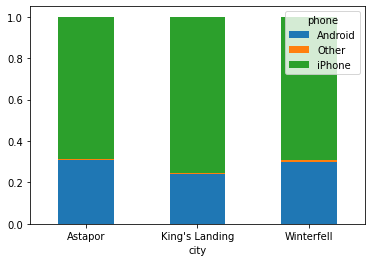

In [ ]:
clean_data.groupby(["city"])["phone"].value_counts(normalize =True).unstack().plot(kind = "bar",stacked =True,rot = 0)

Astapor has higher % of Android customers, which is one of the reasons customers are churning. What is it about Android that makes them churn?

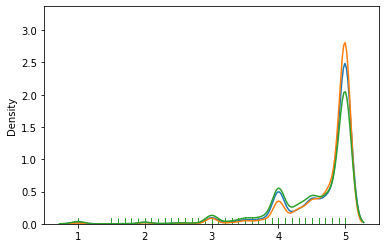

In [ ]:
city_astapor = clean_data.loc[clean_data["city"] == "Astapor"]
city_king_landing = clean_data.loc[clean_data["city"] == "King's Landing"]
city_winterfell = clean_data.loc[clean_data["city"] == "Winterfell"]
sns.distplot(city_astapor[["avg_rating_of_driver"]],rug = True,hist= False,label = "Astapor")
sns.distplot(city_king_landing[["avg_rating_of_driver"]],rug = True,hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["avg_rating_of_driver"]],rug = True,hist= False,label = "Winterfell")
plt.show()

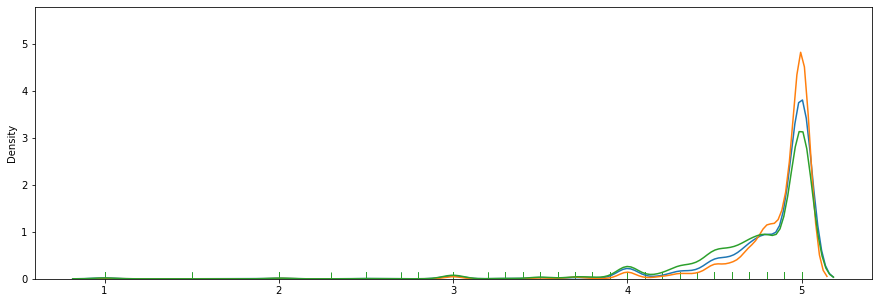

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["avg_rating_by_driver"]],rug = True,hist= False,label = "Astapor")
sns.distplot(city_king_landing[["avg_rating_by_driver"]],rug = True,hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["avg_rating_by_driver"]],rug = True,hist= False,label = "Winterfell")
plt.show()

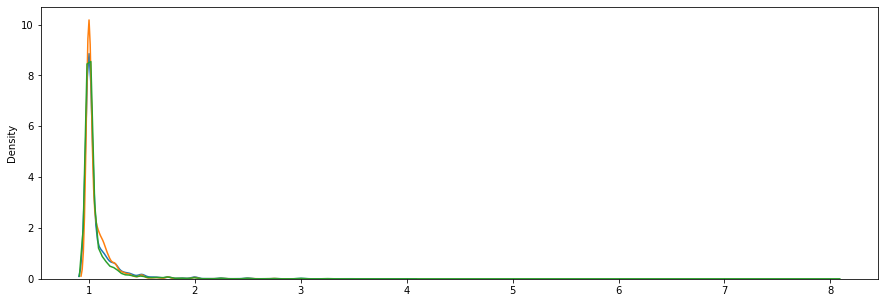

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["avg_surge"]],hist= False,label = "Astapor")
sns.distplot(city_king_landing[["avg_surge"]],hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["avg_surge"]],hist= False,label = "Winterfell")
plt.show()

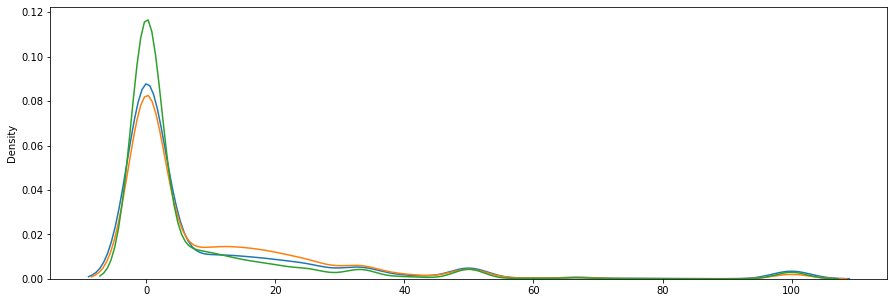

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["surge_pct"]],hist= False,label = "Astapor")
sns.distplot(city_king_landing[["surge_pct"]],hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["surge_pct"]],hist= False,label = "Winterfell")
plt.show()

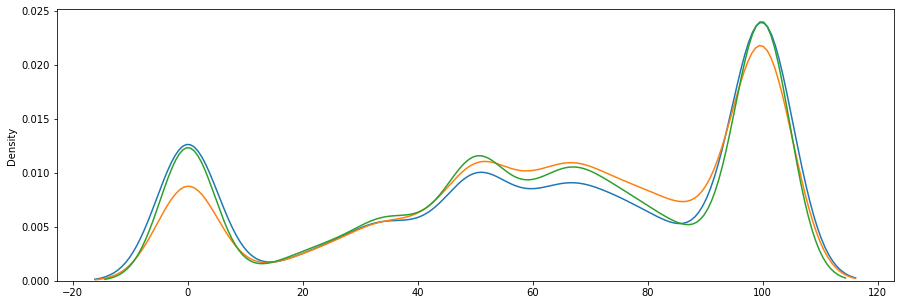

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(city_astapor[["weekday_pct"]],hist= False,label = "Astapor")
sns.distplot(city_king_landing[["weekday_pct"]],hist= False,label = "King's Landing")
sns.distplot(city_winterfell[["weekday_pct"]],hist= False,label = "Winterfell")
plt.show()

Not much of a stark difference between the cities.

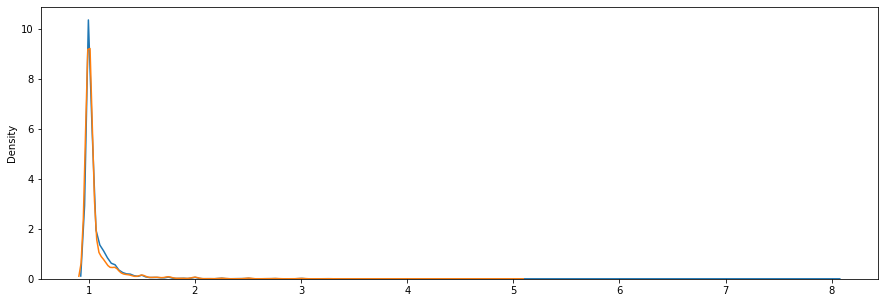

In [ ]:
phone_iphone = clean_data.loc[clean_data["phone"] == "iPhone"]
phone_android = clean_data.loc[clean_data["phone"] == "Android"]
phone_other = clean_data.loc[clean_data["phone"] == "Other"]
plt.figure(figsize = (15,5))
sns.distplot(phone_iphone[["avg_surge"]],hist= False,label = "iPhone")
sns.distplot(phone_android[["avg_surge"]],hist= False,label = "Android")
#sns.distplot(phone_other[["avg_surge"]],hist= False,label = "Other")
plt.show()

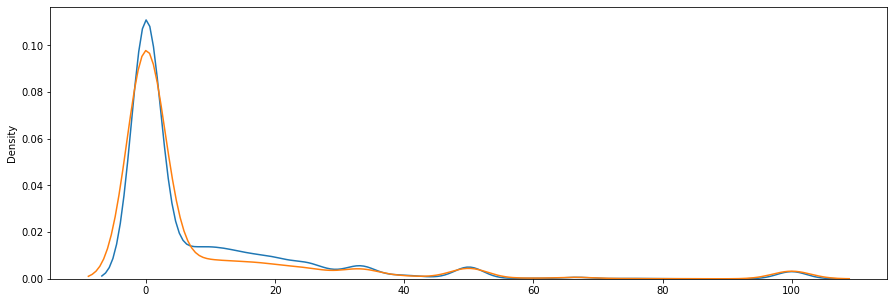

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(phone_iphone[["surge_pct"]],hist= False,label = "iPhone")
sns.distplot(phone_android[["surge_pct"]],hist= False,label = "Android")
#sns.distplot(phone_other[["avg_surge"]],hist= False,label = "Other")
plt.show()

- Ok. So, Android users experience more surge pricing, and that makes them churn.

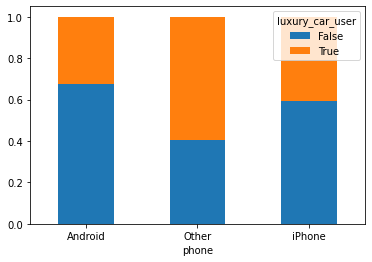

In [ ]:
clean_data.groupby(["phone"])["luxury_car_user"].value_counts(normalize =True).unstack().plot(kind = "bar",stacked =True,rot = 0)

<Figure size 720x360 with 0 Axes>

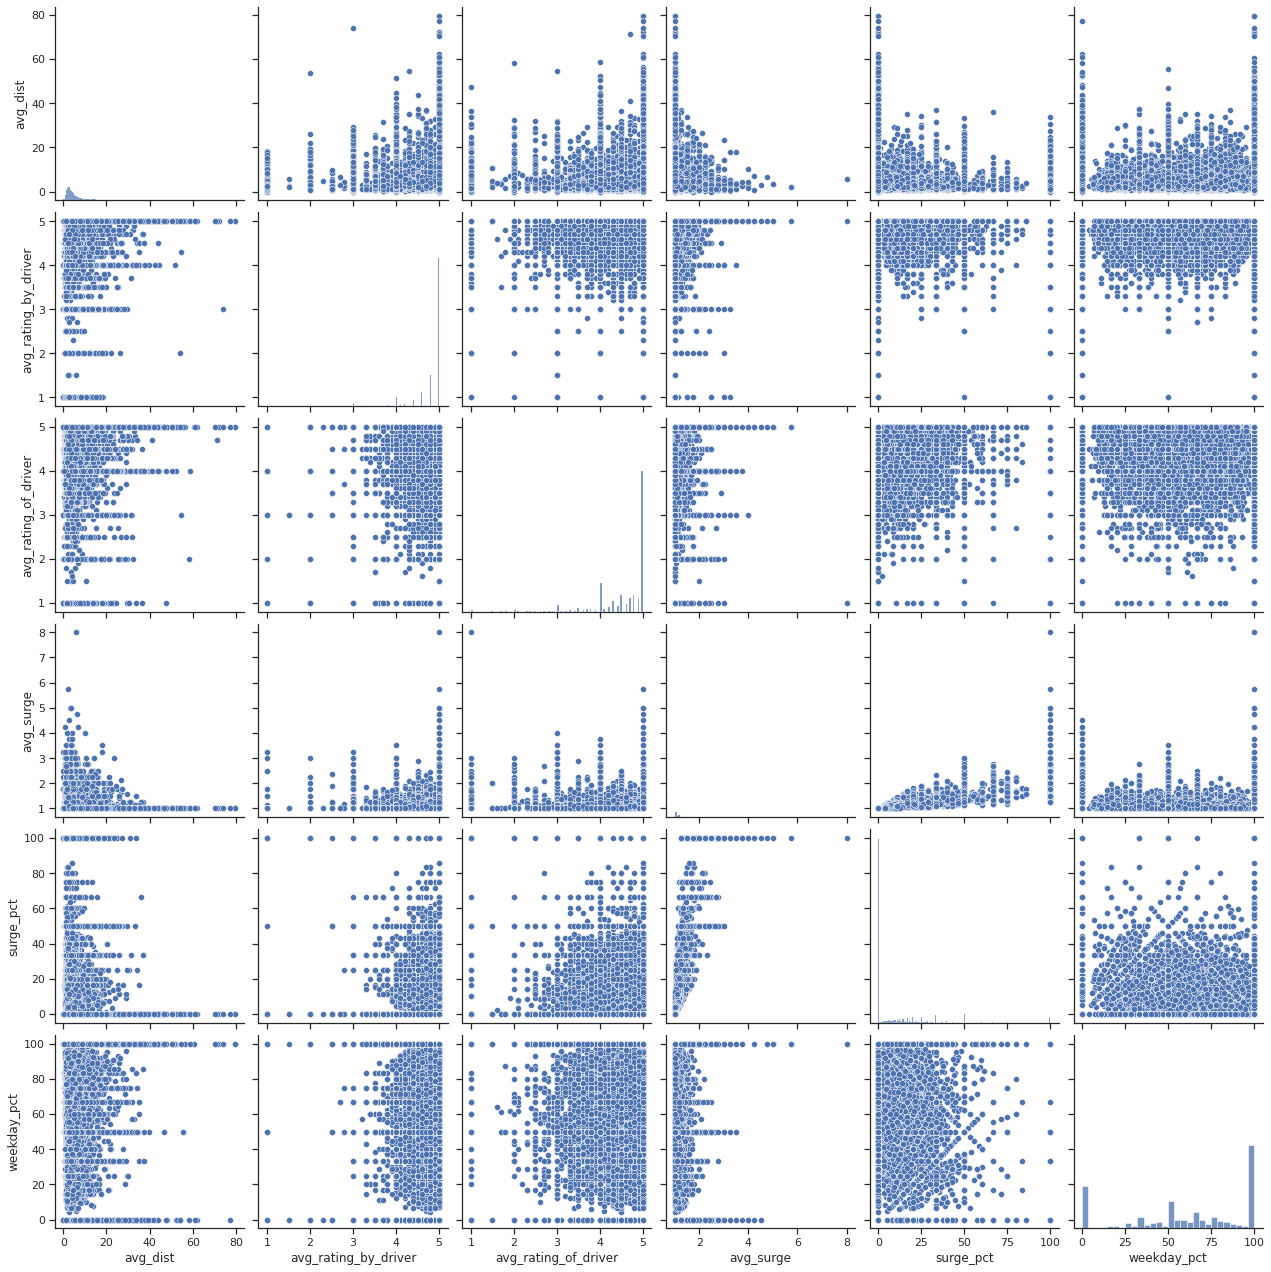

In [ ]:
#Lets also look at scatterplots between our numerical variables
sns.set(style = "ticks",color_codes = True)
cols = separate(clean_data)["continuous"]
#cols.append("luxury_car_user")
plt.figure(figsize = (10,5))
sns.pairplot(clean_data[cols],height =3)
plt.show()

# Feature Engineering
#### - Few variables that makes sense based on insight
* We need a feature indicating Android users face surge pricing more number of times.
* We can also group the avg. ratings of customers - Ratings indicate whether a user is good/bad - we can create variables based on that.
* We can also group the weekday_pct to identify 3 groups of population - those who dont ride during week, those who ride only during week and others.

In [ ]:
#Android users facing surge
clean_data["Android_user_facing_surge"] = 'No'
clean_data["Android_user_facing_surge"][(clean_data["phone"] == "Android") & (clean_data["surge_pct"] != 0)] = "Yes"

In [ ]:
##Converting ratings into a categorical variable
clean_data["customer_behaviour"] = ''
clean_data.customer_behaviour[clean_data.avg_rating_by_driver >= 4] = "good"
clean_data.customer_behaviour[(clean_data.avg_rating_by_driver >= 3) & (clean_data.avg_rating_by_driver < 4)] = "okay"
clean_data.customer_behaviour[clean_data.avg_rating_by_driver < 3] = "bad"

In [ ]:
clean_data["driver_behaviour"] = ''
clean_data.driver_behaviour[clean_data.avg_rating_of_driver >= 4] = "good"
clean_data.driver_behaviour[(clean_data.avg_rating_of_driver >= 3) & (clean_data.avg_rating_of_driver < 4)] = "okay"
clean_data.driver_behaviour[clean_data.avg_rating_of_driver < 3] = "bad"

In [ ]:
#Weekday pct into groups
clean_data["ride_during_week"] = ''
clean_data.ride_during_week[clean_data.weekday_pct == 0] = "none"
clean_data.ride_during_week[clean_data.weekday_pct == 100] = "all"
clean_data.ride_during_week[(clean_data.weekday_pct > 0) & (clean_data.weekday_pct < 100)] = "some"

In [ ]:
#sanity check
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41739 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   avg_dist                   41739 non-null  float64       
 1   avg_rating_by_driver       41739 non-null  float64       
 2   avg_rating_of_driver       41739 non-null  float64       
 3   avg_surge                  41739 non-null  float64       
 4   city                       41739 non-null  object        
 5   phone                      41739 non-null  object        
 6   signup_date                41739 non-null  datetime64[ns]
 7   surge_pct                  41739 non-null  float64       
 8   luxury_car_user            41739 non-null  bool          
 9   weekday_pct                41739 non-null  float64       
 10  churned                    41739 non-null  category      
 11  Android_user_facing_surge  41739 non-null  object        
 12  cust

In [ ]:
#changing rating_by_driver_replaced dtype to object
#clean_data["rating_by_driver_replaced"] = clean_data["rating_by_driver_replaced"].astype("bool")
#clean_data["rating_of_driver_replaced"] = clean_data["rating_of_driver_replaced"].astype("bool")

In [ ]:
#Removing signup_date
clean_data.drop("signup_date",axis =1, inplace = True)
clean_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,luxury_car_user,weekday_pct,churned,Android_user_facing_surge,customer_behaviour,driver_behaviour,ride_during_week
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,True,46.2,0,No,good,good,some
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,False,50.0,1,No,good,good,some
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,False,100.0,1,No,good,good,all
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,True,80.0,0,No,good,good,some
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,False,82.4,1,Yes,good,good,some


# Correlation

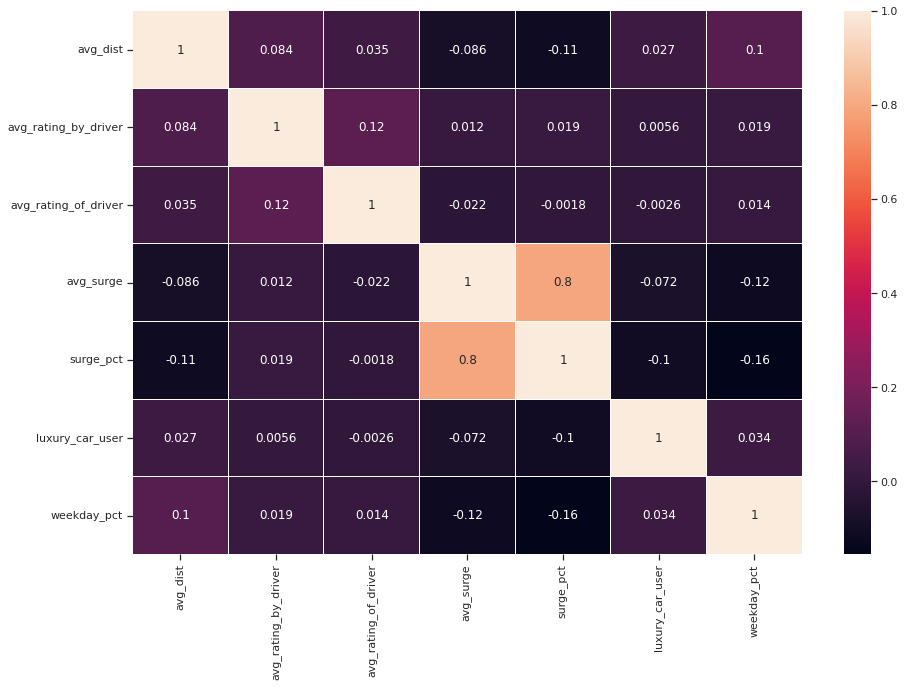

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(clean_data.corr(),annot = True,linewidth = 0.2)
plt.show()

### As seen before, avg_surge and surge_pct are highly correlated! There is little correlation among other variables, but nothing significant. I am going to remove avg_surge as surge_pct gives a better indication of the surge pricing experienced by the customer.

In [ ]:
clean_data.drop("avg_surge",axis = 1,inplace = True)

# Data Preparation

### Dummy variables

In [ ]:
#Converting categorical variables into dummy variables
clean_data = pd.get_dummies(clean_data, drop_first = True,columns = ["city","phone","Android_user_facing_surge","customer_behaviour","driver_behaviour","ride_during_week"])

In [ ]:
#sanity check
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41739 entries, 0 to 49998
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   avg_dist                       41739 non-null  float64 
 1   avg_rating_by_driver           41739 non-null  float64 
 2   avg_rating_of_driver           41739 non-null  float64 
 3   surge_pct                      41739 non-null  float64 
 4   luxury_car_user                41739 non-null  bool    
 5   weekday_pct                    41739 non-null  float64 
 6   churned                        41739 non-null  category
 7   city_King's Landing            41739 non-null  uint8   
 8   city_Winterfell                41739 non-null  uint8   
 9   phone_Other                    41739 non-null  uint8   
 10  phone_iPhone                   41739 non-null  uint8   
 11  Android_user_facing_surge_Yes  41739 non-null  uint8   
 12  customer_behaviour_good        4

In [ ]:
#Before scaling, lets divide our data into training and testing splits
features = [i for i in clean_data.columns if i != "churned"]
target = ["churned"]
X_train, X_test, y_train, y_test = train_test_split(clean_data[features], clean_data[target], test_size=0.2,random_state = 1)

### Scaling the features

In [ ]:
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

## PCA Analysis

In [ ]:
cor_mat1 = np.corrcoef(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat1)
# Looking at sorted eigenvalues
rounded_eigs = [np.around(i,5) for i in eig_vals]
sorted_eigs  = sorted(rounded_eigs, reverse = True)
print('Eigenvalues in descending order:')
for i in sorted_eigs:
    print(i)

Eigenvalues in descending order:
2.71996
2.28698
1.89735
1.59157
1.48426
1.32212
1.08125
0.95152
0.86286
0.81146
0.50822
0.4775
0.44895
0.37853
0.06564
0.05752
0.0543


Most of the variance in the data cannot be explained only by a few principal components. Here, variance is spread across all the components. PCA isn't too helpful.

# Evaluation Metrics - Model Comparison
- Since, the target is to identify churning customers correctly, we need to focus more on getting True Positive correct (High TPR). We can let off False Positive errors (Customers we predicted will churn, but do not!) as they are not that important.
- Also, we need to lower the False Negative error (Customers we predicted will not churn, but they did churn!). In this case, we might lose these customers due to the error.

#### So, our main target would be to - MAXIMIZE TRUE POSITIVES and MINIMIZE FALSE NEGATIVE ERRORS!

#### Metrics we'll look at:
- ROC-AUC curve
- Confusion Matrix

## MODEL COMPARISON METRICS

In [ ]:
def cross_validation(model,xtrain,ytrain, scoretype, folds):
    scores = cross_val_score(estimator = model,X= xtrain, y = ytrain,scoring = scoretype,cv = folds)
    print("%s: %0.3f (+/- %0.2f)" % ("roc-auc",scores.mean(),scores.std()))
    
           
def roc_curve(X_test,y_test,model,model_name):
    from sklearn import metrics
    roc_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    fpr,tpr,threshold = metrics.roc_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label = "Model:" + model_name +(" (AUC) = %0.2f")%roc_auc)
    plt.plot([0,1],[0,1],"r--")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.show()

## MODELLING

### Logistic Regression

In [ ]:
log_model = LogisticRegression(C=0.2,penalty='l2',solver='sag',max_iter=1000,n_jobs=-1,multi_class='multinomial',tol=1e-5)
log_model.fit(X_train, y_train)

LogisticRegression(C=0.2, max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='sag', tol=1e-05)

roc-auc: 0.814 (+/- 0.01)


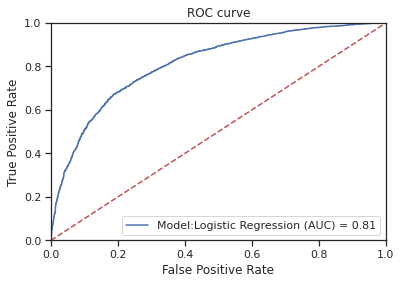

In [ ]:
cross_validation(log_model,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,log_model,"Logistic Regression")

### Decision Tree

In [ ]:
dtree = DecisionTreeClassifier(criterion='entropy',max_depth=8,min_samples_split=10,min_samples_leaf=5,max_features=15,random_state = 42)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=15,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

roc-auc: 0.827 (+/- 0.01)


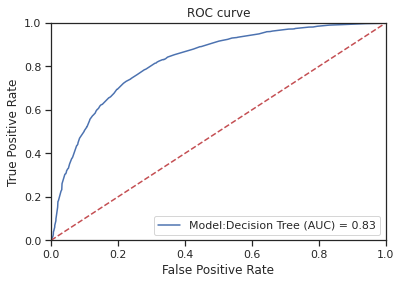

In [ ]:
cross_validation(dtree,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,dtree,"Decision Tree")

### Random Forest

In [ ]:
rf = RandomForestClassifier(criterion='entropy',max_depth=8,min_samples_split=10,min_samples_leaf=5,max_features=10,random_state = 42
                            ,n_estimators=150,max_samples=15000)
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=10,
                       max_samples=15000, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=150, random_state=42)

roc-auc: 0.840 (+/- 0.01)


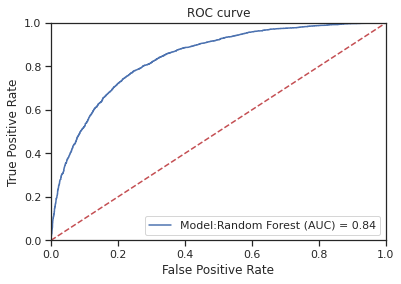

In [ ]:
cross_validation(rf,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,rf,"Random Forest")

### Gradient Boosting

In [ ]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=250,random_state=42,init='zero',min_samples_split=4,min_samples_leaf=2
                                          ,max_depth=2)
gbm.fit(X_train,y_train)

GradientBoostingClassifier(init='zero', max_depth=2, min_samples_leaf=2,
                           min_samples_split=4, n_estimators=250,
                           random_state=42)

roc-auc: 0.844 (+/- 0.01)


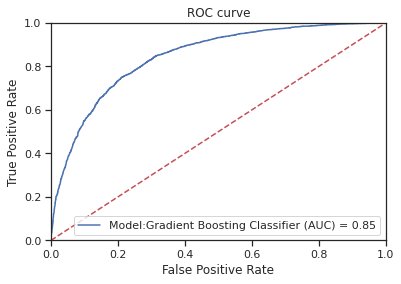

In [ ]:
cross_validation(gbm,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,gbm,"Gradient Boosting Classifier")

### AdaBoost

In [ ]:
ab = ensemble.AdaBoostClassifier(n_estimators=1800,random_state = 30,learning_rate=0.1)
ab.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=1800, random_state=30)

roc-auc: 0.843 (+/- 0.01)


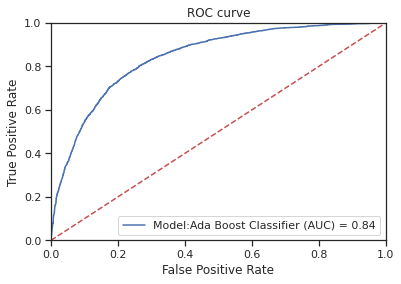

In [ ]:
cross_validation(ab,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,ab,"Ada Boost Classifier")

## CatBoost

In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(random_state = 30)
cb.fit(X_train,y_train)

Learning rate set to 0.046081
0:	learn: 0.6727685	total: 81ms	remaining: 1m 20s
1:	learn: 0.6545925	total: 113ms	remaining: 56.3s
2:	learn: 0.6386584	total: 123ms	remaining: 40.8s
3:	learn: 0.6245907	total: 131ms	remaining: 32.7s
4:	learn: 0.6126771	total: 140ms	remaining: 27.9s
5:	learn: 0.6011926	total: 150ms	remaining: 24.9s
6:	learn: 0.5912206	total: 159ms	remaining: 22.6s
7:	learn: 0.5821183	total: 168ms	remaining: 20.9s
8:	learn: 0.5740490	total: 177ms	remaining: 19.5s
9:	learn: 0.5668820	total: 191ms	remaining: 18.9s
10:	learn: 0.5609128	total: 204ms	remaining: 18.3s
11:	learn: 0.5549966	total: 212ms	remaining: 17.5s
12:	learn: 0.5495361	total: 221ms	remaining: 16.8s
13:	learn: 0.5444745	total: 230ms	remaining: 16.2s
14:	learn: 0.5406297	total: 239ms	remaining: 15.7s
15:	learn: 0.5361336	total: 249ms	remaining: 15.3s
16:	learn: 0.5324020	total: 258ms	remaining: 14.9s
17:	learn: 0.5291483	total: 268ms	remaining: 14.6s
18:	learn: 0.5261967	total: 277ms	remaining: 14.3s
19:	learn: 

Streaming output truncated to the last 5000 lines.
5:	learn: 0.6041548	total: 67.1ms	remaining: 11.1s
6:	learn: 0.5940065	total: 75.3ms	remaining: 10.7s
7:	learn: 0.5845984	total: 83.6ms	remaining: 10.4s
8:	learn: 0.5763234	total: 91.8ms	remaining: 10.1s
9:	learn: 0.5686887	total: 99.7ms	remaining: 9.87s
10:	learn: 0.5626688	total: 108ms	remaining: 9.71s
11:	learn: 0.5573722	total: 116ms	remaining: 9.57s
12:	learn: 0.5518942	total: 125ms	remaining: 9.46s
13:	learn: 0.5471386	total: 134ms	remaining: 9.41s
14:	learn: 0.5425221	total: 142ms	remaining: 9.33s
15:	learn: 0.5388931	total: 151ms	remaining: 9.26s
16:	learn: 0.5351627	total: 159ms	remaining: 9.2s
17:	learn: 0.5317762	total: 168ms	remaining: 9.14s
18:	learn: 0.5286333	total: 182ms	remaining: 9.39s
19:	learn: 0.5256468	total: 198ms	remaining: 9.72s
20:	learn: 0.5230778	total: 210ms	remaining: 9.79s
21:	learn: 0.5201905	total: 219ms	remaining: 9.74s
22:	learn: 0.5177161	total: 228ms	remaining: 9.67s
23:	learn: 0.5152943	total: 236m

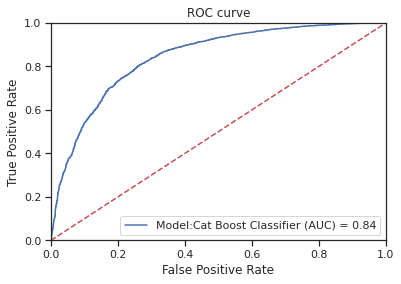

In [ ]:
cross_validation(cb,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,cb,"Cat Boost Classifier")

## Multiple Later Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=500,
                                max_iter=100, shuffle=True, random_state=30
                                )
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=500, max_iter=100, random_state=30,
              solver='lbfgs')

roc-auc: 0.835 (+/- 0.01)


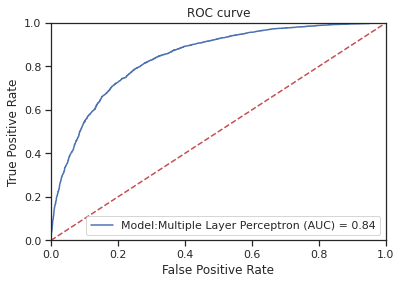

In [ ]:
cross_validation(mlp,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,ab,"Multiple Layer Perceptron")

##XG Boost 

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb=XGBClassifier(random_state=30)
xgb.fit(X_train,y_train)

XGBClassifier(random_state=30)

roc-auc: 0.843 (+/- 0.01)


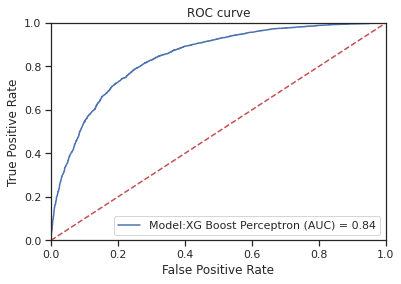

In [ ]:
cross_validation(xgb,X_train,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test,y_test,ab,"XG Boost Perceptron")

## K nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
knn=KNeighborsClassifier(n_neighbors=53,p=2,leaf_size=200,metric='manhattan')
knn.fit(X_train,y_train)

KNeighborsClassifier(leaf_size=200, metric='manhattan', n_neighbors=53)

In [ ]:
cross_validation(knn,X_train,y_train,scoretype = "roc_auc",folds = 10)
#roc_curve(X_test,y_test,knn,"K nearest Neighbour")

roc-auc: 0.831 (+/- 0.01)


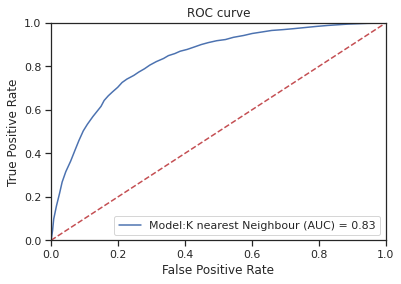

In [ ]:
roc_curve(X_test,y_test,knn,"K nearest Neighbour")

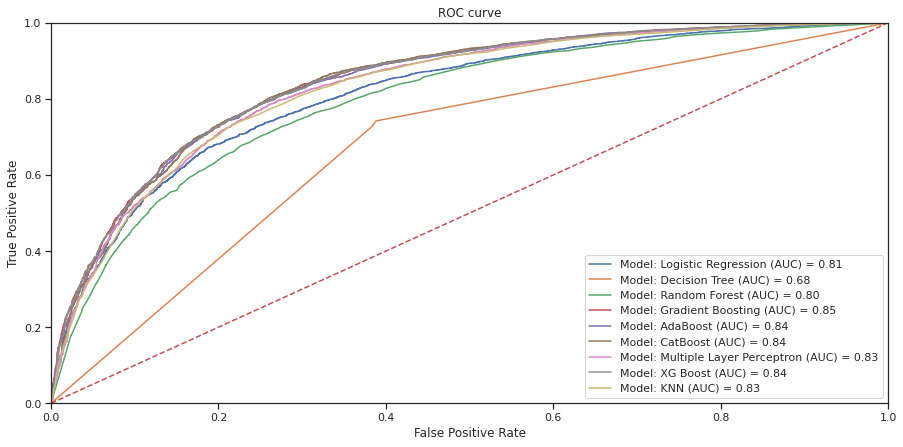

In [ ]:
#combined results
plt.figure(figsize = (15,7))

roc_auc = metrics.roc_auc_score(y_test,log_model.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,log_model.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Logistic Regression" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,dtree.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,dtree.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Decision Tree" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,rf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Random Forest" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,gbm.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,gbm.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Gradient Boosting" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,ab.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,ab.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: AdaBoost" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,cb.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,cb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: CatBoost" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,mlp.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,mlp.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Multiple Layer Perceptron" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,xgb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: XG Boost" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,knn.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,knn.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: KNN" + (" (AUC) = %0.2f")%roc_auc)

plt.plot([0,1],[0,1],"r--")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc = "lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()

We have tried 5 different base models, and all the boosting models have done exceedingly well. Lets short-list all the boosting models, and hyper-tune their parameters and see whether we can improve the performance even further.

## Model Optimization: Hyper-tuning parameters
There are two ways to hyper tune parameters:
    1. Grid Search (takes too much time - will try every combination of parameters provided)
    2. Random Search (takes less time - will try random combinations)

## Model: Logistic Regression

In [ ]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
grid = GridSearchCV(estimator = log_model,param_grid = LRparam_grid,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300, 400, 500, 600, 700],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} 0.813980740646258


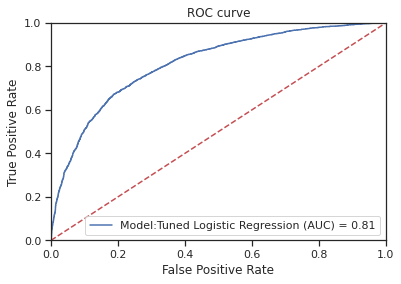

In [ ]:
#Tuned Classifier
log_model_tuned = LogisticRegression(solver='liblinear',penalty='l2',max_iter=100,C=0.1)
log_model_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,log_model_tuned,"Tuned Logistic Regression")

## Model: CatBoost

In [ ]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
param_grid = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04,0.05,0.06],
                  'iterations'    : list(range(100,800,100))
                 }
grid = RandomizedSearchCV(estimator = CatBoostClassifier(),param_distributions = param_grid,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

0:	learn: 0.6761407	total: 13.4ms	remaining: 8.05s
1:	learn: 0.6599520	total: 23.2ms	remaining: 6.93s
2:	learn: 0.6452973	total: 31.7ms	remaining: 6.3s
3:	learn: 0.6320061	total: 40ms	remaining: 5.95s
4:	learn: 0.6199670	total: 48.5ms	remaining: 5.77s
5:	learn: 0.6094281	total: 57.7ms	remaining: 5.72s
6:	learn: 0.5996750	total: 66.2ms	remaining: 5.61s
7:	learn: 0.5908431	total: 76.6ms	remaining: 5.67s
8:	learn: 0.5829721	total: 86.3ms	remaining: 5.67s
9:	learn: 0.5754623	total: 94.7ms	remaining: 5.59s
10:	learn: 0.5686479	total: 103ms	remaining: 5.51s
11:	learn: 0.5627568	total: 112ms	remaining: 5.49s
12:	learn: 0.5576900	total: 121ms	remaining: 5.46s
13:	learn: 0.5525258	total: 129ms	remaining: 5.42s
14:	learn: 0.5477339	total: 138ms	remaining: 5.38s
15:	learn: 0.5437688	total: 146ms	remaining: 5.34s
16:	learn: 0.5397840	total: 155ms	remaining: 5.32s
17:	learn: 0.5363346	total: 164ms	remaining: 5.3s
18:	learn: 0.5327560	total: 172ms	remaining: 5.27s
19:	learn: 0.5296558	total: 182ms	r

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f1c88e08ed0>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [100, 200, 300, 400, 500,
                                                       600, 700],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06]},
                   scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'learning_rate': 0.04, 'iterations': 600, 'depth': 6} 0.8460801047533554


In [ ]:
#Tuning l2_leaf_reg
param_grid_cb_2 = { 'l2_leaf_reg' : [2,3,4,5,6,7,8,9,10]
              }
grid = GridSearchCV(estimator = CatBoostClassifier(learning_rate = 0.04 ,iterations = 600 ,depth=6,random_state = 30),param_grid = param_grid_cb_2,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

0:	learn: 0.6753891	total: 10.8ms	remaining: 6.44s
1:	learn: 0.6592972	total: 22.2ms	remaining: 6.62s
2:	learn: 0.6451708	total: 31.3ms	remaining: 6.23s
3:	learn: 0.6327225	total: 40.3ms	remaining: 6.01s
4:	learn: 0.6206478	total: 49.2ms	remaining: 5.85s
5:	learn: 0.6096675	total: 58ms	remaining: 5.74s
6:	learn: 0.6001973	total: 67.6ms	remaining: 5.73s
7:	learn: 0.5912712	total: 76.5ms	remaining: 5.66s
8:	learn: 0.5833860	total: 89.4ms	remaining: 5.87s
9:	learn: 0.5760572	total: 98.9ms	remaining: 5.83s
10:	learn: 0.5696596	total: 108ms	remaining: 5.8s
11:	learn: 0.5636039	total: 118ms	remaining: 5.77s
12:	learn: 0.5580251	total: 127ms	remaining: 5.73s
13:	learn: 0.5528128	total: 136ms	remaining: 5.68s
14:	learn: 0.5485119	total: 145ms	remaining: 5.66s
15:	learn: 0.5445972	total: 155ms	remaining: 5.65s
16:	learn: 0.5405923	total: 164ms	remaining: 5.62s
17:	learn: 0.5369730	total: 173ms	remaining: 5.58s
18:	learn: 0.5335836	total: 182ms	remaining: 5.55s
19:	learn: 0.5304729	total: 191ms	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1c85c93550>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'l2_leaf_reg': 2} 0.8461625691771723


In [ ]:
#Tuning lrandom strength
param_grid_cb_3 = { 'random_strength' : [0,1,2,3,4,5,6,7,8,9,10]
              }
grid = GridSearchCV(estimator = CatBoostClassifier(learning_rate = 0.04 ,iterations = 600 ,depth=4,l2_leaf_reg=2,random_state = 30),param_grid = param_grid_cb_3,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

0:	learn: 0.6800676	total: 7.23ms	remaining: 4.33s
1:	learn: 0.6665137	total: 13.4ms	remaining: 4.02s
2:	learn: 0.6574873	total: 19.4ms	remaining: 3.86s
3:	learn: 0.6465766	total: 25.7ms	remaining: 3.83s
4:	learn: 0.6370202	total: 32.2ms	remaining: 3.83s
5:	learn: 0.6265984	total: 38.5ms	remaining: 3.81s
6:	learn: 0.6206833	total: 45ms	remaining: 3.81s
7:	learn: 0.6147960	total: 51ms	remaining: 3.77s
8:	learn: 0.6066468	total: 57.1ms	remaining: 3.75s
9:	learn: 0.6010484	total: 63ms	remaining: 3.72s
10:	learn: 0.5953414	total: 69.3ms	remaining: 3.71s
11:	learn: 0.5898658	total: 75.7ms	remaining: 3.71s
12:	learn: 0.5844389	total: 82.5ms	remaining: 3.72s
13:	learn: 0.5794943	total: 88.4ms	remaining: 3.7s
14:	learn: 0.5761672	total: 94.3ms	remaining: 3.68s
15:	learn: 0.5731777	total: 101ms	remaining: 3.68s
16:	learn: 0.5693499	total: 107ms	remaining: 3.68s
17:	learn: 0.5658107	total: 116ms	remaining: 3.74s
18:	learn: 0.5621084	total: 123ms	remaining: 3.75s
19:	learn: 0.5584668	total: 129ms

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1c8434b2d0>,
             n_jobs=-1,
             param_grid={'random_strength': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'random_strength': 5} 0.8459300813615375


0:	learn: 0.6775876	total: 38.2ms	remaining: 22.9s
1:	learn: 0.6699611	total: 59ms	remaining: 17.6s
2:	learn: 0.6569671	total: 86.6ms	remaining: 17.2s
3:	learn: 0.6464339	total: 115ms	remaining: 17.2s
4:	learn: 0.6391851	total: 127ms	remaining: 15.1s
5:	learn: 0.6284811	total: 137ms	remaining: 13.6s
6:	learn: 0.6227099	total: 150ms	remaining: 12.7s
7:	learn: 0.6141645	total: 162ms	remaining: 12s
8:	learn: 0.6051438	total: 172ms	remaining: 11.3s
9:	learn: 0.5997850	total: 183ms	remaining: 10.8s
10:	learn: 0.5950773	total: 195ms	remaining: 10.4s
11:	learn: 0.5877260	total: 205ms	remaining: 10.1s
12:	learn: 0.5847893	total: 214ms	remaining: 9.65s
13:	learn: 0.5792509	total: 250ms	remaining: 10.4s
14:	learn: 0.5722839	total: 277ms	remaining: 10.8s
15:	learn: 0.5669841	total: 301ms	remaining: 11s
16:	learn: 0.5630295	total: 328ms	remaining: 11.2s
17:	learn: 0.5591584	total: 360ms	remaining: 11.6s
18:	learn: 0.5544620	total: 384ms	remaining: 11.8s
19:	learn: 0.5514946	total: 412ms	remaining:

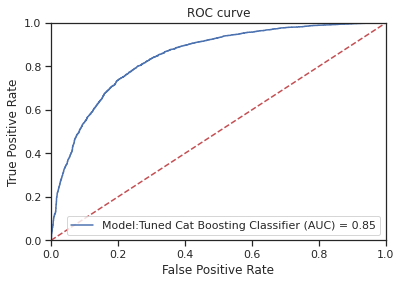

In [ ]:
#Tuned Classifier
cb_tuned = CatBoostClassifier(learning_rate = 0.04 ,iterations = 600 ,depth=6,l2_leaf_reg=2,random_strength=5,random_state = 30)
cb_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,cb_tuned,"Tuned Cat Boosting Classifier")

##Model: XG Boost

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

    

In [ ]:
def objective(space):
    xgb=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    xgb.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7206516530905606
SCORE:
0.7196933397220892
SCORE:
0.7169381887877336
SCORE:
0.7202922855773838
SCORE:
0.7206516530905606
SCORE:
0.7230474365117393
SCORE:
0.7193339722089123
SCORE:
0.7205318639195016
SCORE:
0.7202922855773838
SCORE:
0.7201724964063249
SCORE:
0.7212505989458553
SCORE:
0.7198131288931481
SCORE:
0.7212505989458553
SCORE:
0.7212505989458553
SCORE:
0.7213703881169142
SCORE:
0.7169381887877336
SCORE:
0.7212505989458553
SCORE:
0.7205318639195016
SCORE:
0.7208912314326785
SCORE:
0.7207714422616196
SCORE:
0.7218495448011499
SCORE:
0.7218495448011499
SCORE:
0.7210110206037375
SCORE:
0.7218495448011499
SCORE:
0.7208912314326785
SCORE:
0.7216099664590321
SCORE:
0.7207714422616196
SCORE:
0.7208912314326785
SCORE:
0.7206516530905606
SCORE:
0.7214901772879732
SCORE:
0.7198131288931481
SCORE:
0.7202922855773838
SCORE:
0.7159798754192621
SCORE:
0.719932918064207
SCORE:
0.7193339722089123
SCORE:
0.7198131288931481
SCORE:
0.7228078581696215
SCORE:
0.7198131288931481
SCORE:
0.7207

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9976584026886246, 'gamma': 8.789981481914698, 'max_depth': 15.0, 'min_child_weight': 4.0, 'reg_alpha': 46.0, 'reg_lambda': 0.6173871155052599}


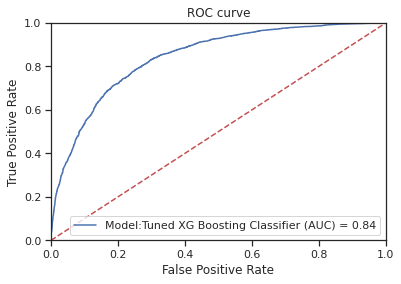

In [ ]:
#Tuned Classifier
xgb_tuned = XGBClassifier(colsample_bytree = 0.9976584026886246 ,gamma = 8.789981481914698 , max_depth=15, min_child_weight=4.0, reg_alpha=46.0, reg_lambda=0.6173871155052599, random_state = 30)
xgb_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,xgb_tuned,"Tuned XG Boosting Classifier")

### Model 1: Light Gradient Boosting 
There are a lot of hyper-parameters to tune. Lets first tune Gradient Boosting Classifier.
The key parameters we will tune here are:
    1. number of estimators
    2. max_Depth
    3. Learning rate

There are other tree-related paramters such as min_samples_split; min_samples_leaf; sub-sample; max_features that we can tune. But we will not do that here.

We will tune each of these hyper-paramters in stages.

#### Grid-Search

In [ ]:
import lightgbm as lgb

In [ ]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
param_grid_gb_1 = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

grid = RandomizedSearchCV(estimator = lgb.LGBMClassifier(),param_distributions = param_grid_gb_1,n_jobs =-1,scoring = "roc_auc",n_iter=50)
grid.fit(X_train,y_train)

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'goss',
                                                          'dart'],
                                        'class_weight': [None, 'balanced'],
                                        'colsample_bytree': [0.6,
                                                             0.6444444444444444,
                                                             0.6888888888888889,
                                                             0.7333333333333333,
                                                             0.7777777777777778,
                                                             0.8222222222222222,
                                                             0.8666666666666667,
                                                             0.9111111111111111,
                                                             0.9555555555555555,


In [ ]:
print(grid.best_params_, grid.best_score_)

{'subsample_for_bin': 80000, 'reg_lambda': 0.836734693877551, 'reg_alpha': 0.6530612244897959, 'num_leaves': 87, 'min_child_samples': 440, 'learning_rate': 0.08649646245384768, 'colsample_bytree': 0.6888888888888889, 'class_weight': 'balanced', 'boosting_type': 'gbdt'} 0.8453231336785041


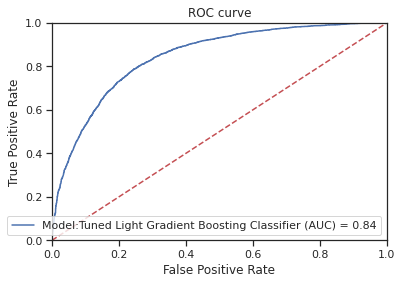

In [ ]:
#Tuned Classifier
gbm_tuned = lgb.LGBMClassifier(subsample_for_bin =80000 ,reg_lambda =0.836734693877551 ,reg_alpha = 0.6530612244897959, num_leaves =87,
                             min_child_samples=440, learning_rate=0.08649646245384768, colsample_bytree=0.6888888888888889,class_weight='balanced',
                              boosting_type='gbdt')
#gbm_tuned = ensemble.GradientBoostingClassifier()
gbm_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,gbm_tuned,"Tuned Light Gradient Boosting Classifier")

## ---------------------------------

##Model:Gradient Boosting Main

In [ ]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
param_grid_gbmM_1 = { 'learning_rate' : [0.01,0.1,1,10,100],
              'n_estimators' :[5,50,250,500],
              }
grid = RandomizedSearchCV(estimator = ensemble.GradientBoostingClassifier(),param_distributions = param_grid_gbmM_1,n_jobs =-1,scoring = "roc_auc",n_iter=10)
grid.fit(X_train,y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'n_estimators': [5, 50, 250, 500]},
                   scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'n_estimators': 250, 'learning_rate': 0.1} 0.8452800057968297


In [ ]:
#Tuning max_depth
param_grid_gbM_2 = { 'max_depth' : [1,3,5,7,9]
              }
grid = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 250 ),param_grid = param_grid_gbM_2,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(n_estimators=250),
             n_jobs=-1, param_grid={'max_depth': [1, 3, 5, 7, 9]},
             scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'max_depth': 3} 0.8452473925497447


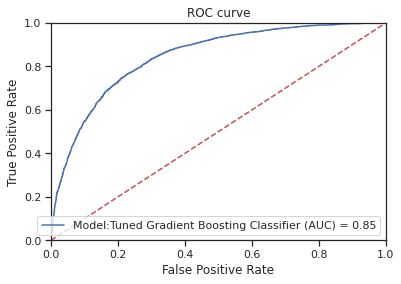

In [ ]:
#Tuned Classifier
gbm_tuned = ensemble.GradientBoostingClassifier(learning_rate =0.1 ,n_estimators =150 ,random_state = 42, max_depth =3,subsample=0.9,min_samples_split=20
                                                )
#gbm_tuned = ensemble.GradientBoostingClassifier()
gbm_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,gbm_tuned,"Tuned Gradient Boosting Classifier")

##Model: Multiple Layer Perceptor

In [ ]:
param_grid_mlp_one = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100, 150],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = RandomizedSearchCV(estimator = MLPClassifier(),param_distributions = param_grid_mlp_one,n_jobs =-1,scoring = "roc_auc",n_iter=10)
grid.fit(X_train,y_train)

RandomizedSearchCV(estimator=MLPClassifier(), n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(150, 100, 50),
                                                               (120, 80, 40),
                                                               (100, 50, 30)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': [50, 100, 150],
                                        'solver': ['sgd', 'adam']},
                   scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'solver': 'adam', 'max_iter': 50, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50, 30), 'alpha': 0.05, 'activation': 'tanh'} 0.8386111451936493


In [ ]:
space_mlp={'hidden_layer_sizes': hp.choice('hidden_layer_sizes', ['(150,100,50)', '(120,80,40)', '(100,50,30)']),
        'max_iter': hp.uniform ('max_iter', 50,200,10),
        'activation' : hp.choice('activation', ['tanh', 'relu', 'logistic']),
        'solver' : hp.choice('solver', ['sgd', 'adam']),
        'alpha' : hp.uniform('alpha', 0.05,0.08),
        'learning_rate' : hp.choice('learning_rate', ['constant', 'adaptive'])
      
    }


In [ ]:
def objective_mlp(space_mlp):
    mlp=MLPClassifier(
                   hidden_layer_sizes =space_mlp['hidden_layer_sizes'], max_iter = int(space_mlp['max_iter']), activation = space_mlp['activation'],
                   solver = space_mlp['solver'],alpha = space_mlp['alpha'],learning_rate = space_mlp['learning_rate']
                    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    mlp.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space_mlp,
                        algo = tpe.suggest,
                        max_evals = 100,
                        )

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


TypeError: ignored

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.842584676406338, 'gamma': 8.848715553199852, 'max_depth': 7.0, 'min_child_weight': 9.0, 'reg_alpha': 40.0, 'reg_lambda': 0.7309498684538512}


### Model 2: AdaBoost

In [ ]:
#Tuning learning-rate and number of trees - with change in learning rate, we are adjusting number of estimators as well
param_grid = { 'learning_rate' : [0.15,0.1,0.05,0.01,0.005,0.001],
              'n_estimators' :[100,250,500,750,1000,1250,1500,1750],
              }
grid = RandomizedSearchCV(estimator = ensemble.AdaBoostClassifier(),param_distributions = param_grid,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000, 1250, 1500,
                                                         1750]},
                   scoring='roc_auc')

In [ ]:
print(grid.best_params_, grid.best_score_)

{'n_estimators': 1750, 'learning_rate': 0.15} 0.8430367264149867


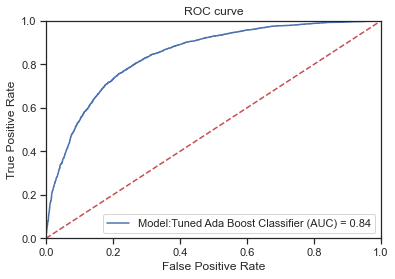

In [ ]:
#Tuned Classifier
ab_tuned = ensemble.AdaBoostClassifier(learning_rate = 0.15 ,n_estimators = 1750 ,random_state = 42)
ab_tuned.fit(X_train,y_train)
roc_curve(X_test,y_test,ab_tuned,"Tuned Ada Boost Classifier")

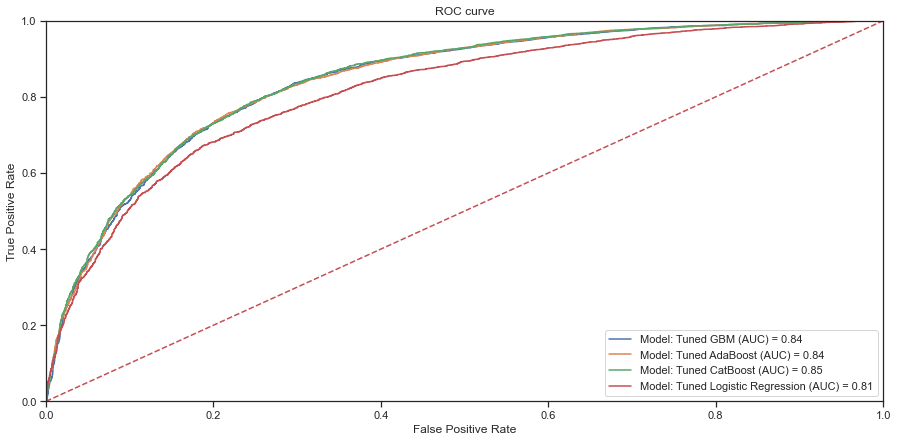

In [ ]:
# Combined results
#combined results
plt.figure(figsize = (15,7))

roc_auc = metrics.roc_auc_score(y_test,gbm_tuned.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,gbm_tuned.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Tuned GBM" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,ab_tuned.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,ab_tuned.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Tuned AdaBoost" + (" (AUC) = %0.2f")%roc_auc)

roc_auc = metrics.roc_auc_score(y_test,cb_tuned.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,cb_tuned.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Tuned CatBoost" + (" (AUC) = %0.2f")%roc_auc)


roc_auc = metrics.roc_auc_score(y_test,log_model_tuned.predict_proba(X_test)[:,1])
fpr,tpr,threshold = metrics.roc_curve(y_test,log_model_tuned.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label = "Model: Tuned Logistic Regression" + (" (AUC) = %0.2f")%roc_auc)





plt.plot([0,1],[0,1],"r--")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc = "lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()

The optimized results for both models are quite similiar, but we will select the tuned Gradient Boosted Classifer as our final model.

# Final Predicted Probabilities

In [ ]:
predictions = gbm_tuned.predict_proba(X_test)[:,1]
predictions

array([0.76148851, 0.05641078, 0.94424031, ..., 0.93586545, 0.14400444,
       0.92145139])

# Choosing an Optimal Threshold
Now, we have our final model in the tuned Gradient Boosting with an ROC-AUC equal to 0.84.

To get the best possible predictions, we need to choose an optimal threshold.

- Since, it is a binary classification problem, we have 4 possible outcomes (TP, TN, FP and FN), and in a business, all 4 have a cost associated to it. Since, the threshold affects all the 4 outcomes, I need to assign a cost to each.


#### Assigning Costs

What are the costs for each outcome? It usually varies for each business setting. Lets make some assumptions here.
- Firstly, the cost of True Negative(TN) would be equal to USD 0. This outcome essentially means, that we have correctly identifed customers who are NOT going to churn, and therefore, we dont need to do anything.
- False Negatives are the biggest concern for us. Those are the customers that we incorrectly predicted as not going to churn. We lose these customers, as we will not be taking any action here, and therefore, we will have to pay all the costs of acquiring a replacement customer (including revenue, advertising costs, administrative costs, POS costs, etc.) A quick Google search revealed, such costs vary for every company, but it takes roughly around \$70 for ride-share companies to acquire a new customer.
- Finally, for customers that we correctly identified as churning, lets assume the company would give a retention incentive in the form of discounts which could cost company around USD 20. 
If my Uber gave me such a discount, thats around 2 rides for me and I'd certainly think before leaving. This would be the cost for both True Positive and False Positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the USD 20 concession. We probably could have spent that \$20 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

Instead of optimizing based on number of customers, we'll select the final model based on minimizing the cost function.

The cost function:

70 * FN(C) + 0 * TN(C) + 20 * FP(C) + 20 * TP(C)

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is smallest.

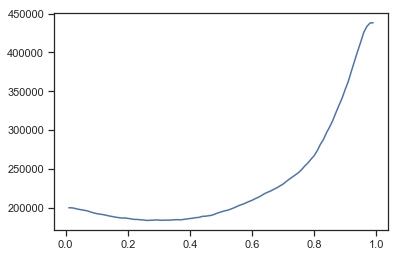

Cost is minimized near a cutoff of: 0.26 for a cost of: 183720


In [ ]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 20], [70, 20]]) * 
                              metrics.confusion_matrix(y_test,np.where(predictions > c, 1, 0))                              )
                       )
                )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

- This chart shows that picking a low threshold works in the best interest as 63% of customers are churning (previously observed!). If we give all the customers a retention incentive, it would cost us around USD 200,000. However, with this model and the threshold of 0.26, the overall cost can be minimized at USD 183,720. The graph also shows, how not taking any action would be disastrous as the costs are sky-rocketing at USD 438,130.

In [ ]:
final_predictions = np.where(predictions > cutoffs[np.argmin(costs)],1,0)

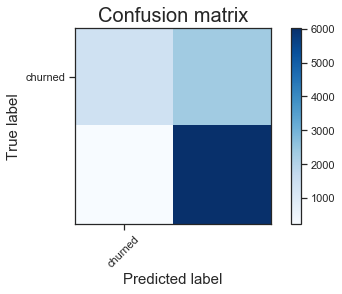

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """ Plot a confusion matrix"""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(set(y_test)))
    plt.xticks(tick_marks, set(y_test), rotation=45)
    plt.yticks(tick_marks, set(y_test))
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
cm = metrics.confusion_matrix(y_test,final_predictions)
plot_confusion_matrix(cm)

In [ ]:
print("Overall accuracy on the model:",metrics.accuracy_score(y_test,final_predictions))

Overall accuracy on the model: 0.7417741774177418


# Factors driving customers to churn

In [ ]:
temp = pd.DataFrame({'features': features, 'importance': gbm_tuned.feature_importances_}).sort_values('importance',ascending = False)
temp

,features,importance
18,ride_during_week_some,0.335231
8,city_King's Landing,0.168740
1,avg_rating_by_driver,0.149428
3,surge_pct,0.119991
11,phone_iPhone,0.090022
4,luxury_car_user,0.069304
5,weekday_pct,0.021665
0,avg_dist,0.020130
9,city_Winterfell,0.015161
2,avg_rating_of_driver,0.009357


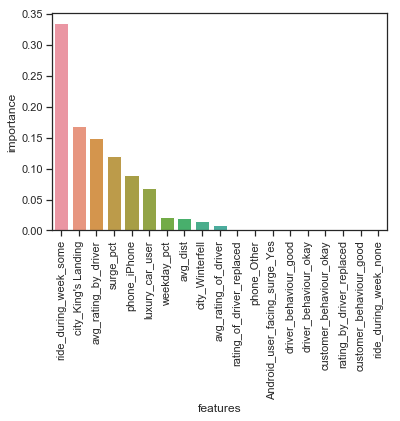

In [ ]:
chart = sns.barplot(x = "features",y = "importance",data = temp)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

# Final Take:

Not taking any action on the customers, would cost the company a lot of money- around USD 438,000. With usage of the model and analysis, company can reach out to the churning customers with incentives and minimize the cost to USD 183,000.

- Also, Android users are expriencing a higher surge charge compared to iPhone users - and that is causing them to churn.
- Customers in Astapor are churning more and King's Landing are less likely to churn.
- Also, company should promote usage of luxury_car in the first 30 days as it is promoting retention.
- Finally, riding during the week and ratings provided by the driver are important factors to look for to identify churning customers.



#### - Extensions
- Some customers who receive retention incentives will still churn. Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.
